<a href="https://colab.research.google.com/github/vmpreciado/NETS3120/blob/main/CommunitiesKatzSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will generate a network embedding for the Zachary's Karate Club based on similarities.
We start by loading the network and building the matrix of similarities. In this illustration, we use the pairwise Katz centrality to measure the similarities between every pair of nodes.

In [1]:
import networkx as nx
import numpy as np

# Load the Zachary Karate Club network
G = nx.karate_club_graph()

# Parameters for Katz centrality
alpha = 0.05  # attenuation factor, must be less than the reciprocal of the largest eigenvalue of the adjacency matrix
beta = 1.0    # scalar or vector of length equal to the number of nodes, setting all to 1.0 for simplicity
max_power = 10  # maximum path length to consider, to ensure convergence

# Initialize matrix for pair-wise Katz centrality scores
N = len(G.nodes())
katz_matrix = np.zeros((N, N))

# Compute the adjacency matrix of the graph and binarize it to make it unweighted
A = nx.to_numpy_array(G)
A = (A > 0).astype(int)  # Binarize the adjacency matrix

# Compute pair-wise Katz centrality
I = np.eye(N)
for n in range(1, max_power + 1):
    katz_matrix += np.linalg.matrix_power(A, n) * (alpha ** n)

# Since Katz centrality includes direct connections, add the identity matrix scaled by beta
katz_matrix += I * beta

# Display the Katz centrality matrix
print("Pair-wise Katz centrality matrix:")
print(katz_matrix)

Pair-wise Katz centrality matrix:
[[1.04814798 0.07453859 0.07009926 ... 0.0542763  0.01063178 0.01381202]
 [0.07453859 1.02739774 0.06603371 ... 0.00488066 0.00758296 0.01063902]
 [0.07009926 0.06603371 1.0300507  ... 0.01026391 0.05802036 0.019926  ]
 ...
 [0.0542763  0.00488066 0.01026391 ... 1.01674088 0.05746592 0.06082198]
 [0.01063178 0.00758296 0.05802036 ... 0.05746592 1.03595695 0.08307869]
 [0.01381202 0.01063902 0.019926   ... 0.06082198 0.08307869 1.05029175]]


Let's compute the d-dimensional embedding of the nodes based on the matrix factorization of the similarity matrix...

In [2]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(katz_matrix)

# Sort the eigenvalues in descending order, and get the indices
sorted_indices = np.argsort(eigenvalues)[::-1]

# Select the d largest eigenvalues and their corresponding eigenvectors
d = 2  # Dimensionality of the embedding
selected_eigenvectors = eigenvectors[:, sorted_indices[:d]]

# The selected eigenvectors form the d-dimensional node embedding
node_embedding = selected_eigenvectors.real

print("2-dimensional node embedding:")
print(node_embedding)

2-dimensional node embedding:
[[-0.35549144 -0.38686107]
 [-0.26595992 -0.26893952]
 [-0.3171925  -0.13115956]
 [-0.21117972 -0.25294583]
 [-0.07596882 -0.13389698]
 [-0.07948305 -0.14565715]
 [-0.07948305 -0.14565715]
 [-0.17095975 -0.20893922]
 [-0.22740391  0.05501457]
 [-0.10267425  0.04810648]
 [-0.07596882 -0.13389698]
 [-0.0528557  -0.07772861]
 [-0.08425463 -0.12855081]
 [-0.22647272 -0.13447999]
 [-0.10140326  0.13966939]
 [-0.10140326  0.13966939]
 [-0.02363563 -0.05853123]
 [-0.09239954 -0.13176428]
 [-0.10140326  0.13966939]
 [-0.14791251 -0.05730506]
 [-0.10140326  0.13966939]
 [-0.09239954 -0.13176428]
 [-0.10140326  0.13966939]
 [-0.15011857  0.21704695]
 [-0.05705244  0.05641262]
 [-0.05920647  0.07548493]
 [-0.07557941  0.11596526]
 [-0.13347715  0.10305032]
 [-0.13107782  0.06864757]
 [-0.13496082  0.20657862]
 [-0.1747583   0.09668732]
 [-0.19103384  0.10223455]
 [-0.30864422  0.32455583]
 [-0.37336347  0.37058908]]


Let's plot the graph using this 2D embedding...

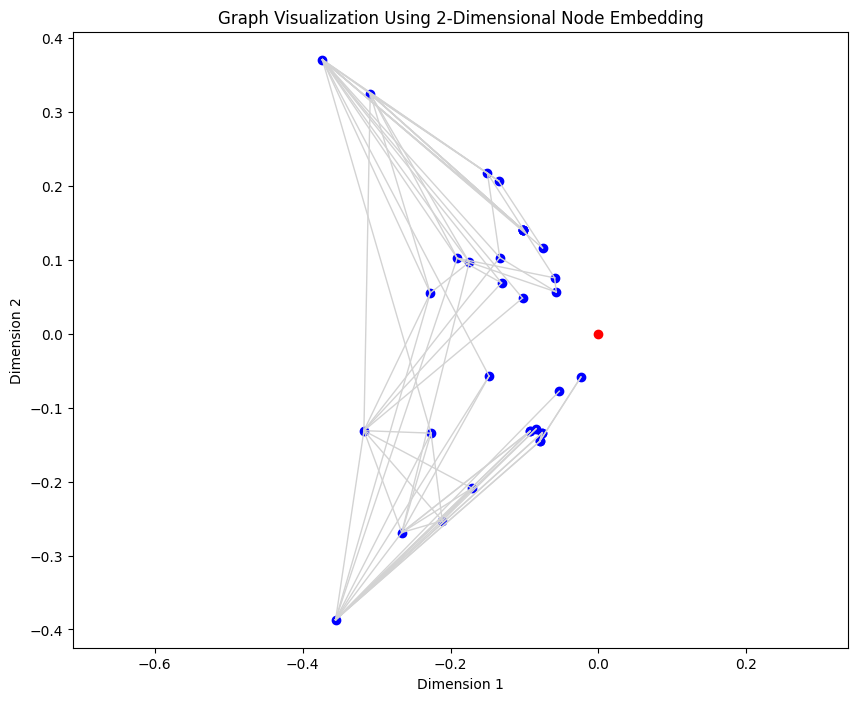

In [3]:
import matplotlib.pyplot as plt

# Extract the x and y coordinates of each node from the node_embedding
x = node_embedding[:, 0]
y = node_embedding[:, 1]

# Create a plot
plt.figure(figsize=(10, 8))

# Plot the edges in gray color
for edge in G.edges():
    x0, y0 = node_embedding[edge[0]]
    x1, y1 = node_embedding[edge[1]]
    plt.plot([x0, x1], [y0, y1], color='lightgray', linestyle='-', linewidth=1)

# Plot the nodes using the x and y coordinates
plt.scatter(x, y, color='blue')

# Mark the origin (0,0) in red
plt.scatter([0], [0], color='red', zorder=5)

plt.title('Graph Visualization Using 2-Dimensional Node Embedding')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the plot more intuitive
plt.show()

To perform K-means clustering using the inner product as a measure of similarity, we need to adjust the standard K-means algorithm. The standard K-means algorithm minimizes the sum of squared Euclidean distances between points and their respective cluster centroids. To use the inner product for clustering, we want to maximize the sum of inner products between points and their respective cluster centroids, as a high inner product indicates high similarity.

The modified K-means algorithm can be outlined as follows:

1. Initialize: K centroids randomly.

2. Assign each point to the cluster whose centroid has the highest inner product with the point.

3. Update each centroid by calculating the mean of all points assigned to that centroid, aiming to maximize the inner product within the cluster. This step is less straightforward because the direct mean does not necessarily maximize the inner product. A potential adjustment is to consider the direction that maximizes the inner product with the points in the cluster.

4. Repeat steps 2 and 3 until convergence, i.e., when the assignments no longer change or after a set number of iterations.

Here's how you could implement this algorithm in Python. Note that due to the nature of the task—maximizing inner products—the "mean" in step 3 doesn't apply directly. Instead, we'll update centroids by averaging the vectors in the cluster, acknowledging that this approach seeks to approximate the goal of maximizing inner products within clusters:

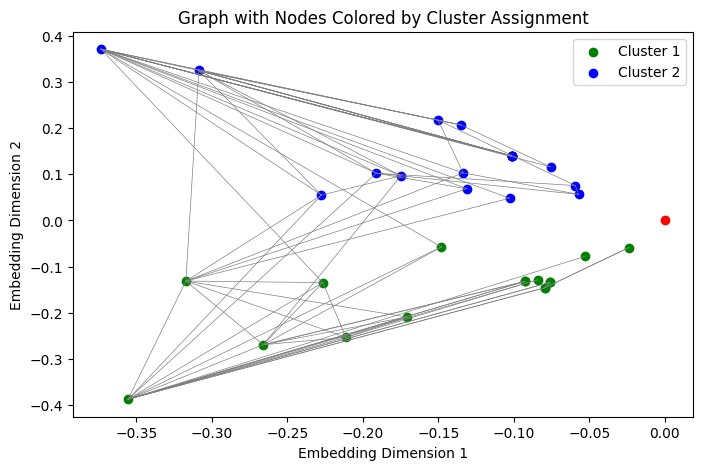

In [8]:
# First, let's define the adapted K-means clustering function with inner product as similarity measure

def initialize_centroids(points, k):
    indices = np.random.choice(points.shape[0], k, replace=False)
    return points[indices]

def assign_clusters(points, centroids):
    similarity = np.dot(points, centroids.T)
    return np.argmax(similarity, axis=1)

def update_centroids(points, assignments, k):
    centroids = np.zeros((k, points.shape[1]))
    for i in range(k):
        cluster_points = points[assignments == i]
        if cluster_points.size == 0:
            centroids[i] = points[np.random.choice(points.shape[0])]
        else:
            centroids[i] = cluster_points.mean(axis=0)
    return centroids

def kmeans_inner_product(points, k, max_iterations=100):
    centroids = initialize_centroids(points, k)
    for iteration in range(max_iterations):
        assignments = assign_clusters(points, centroids)
        new_centroids = update_centroids(points, assignments, k)
        if np.array_equal(centroids, new_centroids):
            break
        centroids = new_centroids
    return assignments, centroids

# Now, perform K-means clustering using the inner product on the node embedding
k = 2
assignments, centroids = kmeans_inner_product(node_embedding, k)

# Plot the graph with nodes colored based on their cluster assignment
plt.figure(figsize=(8, 5))

# Nodes
colors = ['green', 'blue']
for i in range(k):
    plt.scatter(node_embedding[assignments == i, 0], node_embedding[assignments == i, 1], color=colors[i], label=f'Cluster {i+1}')

# Edges
for edge in G.edges():
    points = [node_embedding[edge[0]], node_embedding[edge[1]]]
    plt.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], color='gray', linestyle='-', linewidth=0.5)

# Mark the origin (0,0) in red
plt.scatter([0], [0], color='red', zorder=5)

plt.title('Graph with Nodes Colored by Cluster Assignment')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
#plt.axis('equal')  # Ensure the aspect ratio is equal to make the plot more intuitive
plt.show()